In [1]:
import torchvision
import torchvision.transforms as CVtransforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time


In [2]:
np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
BATCH_SIZE  = 64
N_EPOCHS = 10
IMAGE_SIZE = 28 * 28
LATENT_DIM = 100

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
transforms = CVtransforms.Compose([
    CVtransforms.ToTensor(),
    CVtransforms.Normalize((0.5,), (0.5,))
    ])


In [7]:
dataset = datasets.MNIST('.data', 
                        train=True, 
                        download=True, 
                        transform=transforms,
                        )

train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [8]:
train_iterator = DataLoader(train_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      drop_last=True,
                     )


val_iterator = DataLoader(val_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      drop_last=True,
                     )

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
def toImage(tensor):
    transf = CVtransforms.ToPILImage()
    return transf(tensor)

def addNoise(tensor,mean=0.,std=1.):
    transf = AddGaussianNoise(mean, std)
    return transf(tensor)
    

torch.Size([64, 1, 28, 28])


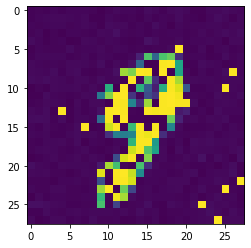

In [10]:
noise_mean = 0.01
noise_var = 0.008

for data, label in train_iterator:
    print(data.shape)
    data = addNoise(data,noise_mean,noise_var) #(noise_mean**noise_var)*torch.randn([BATCH_SIZE,1, 28, 28])
    img = toImage(data[0])
    plt.imshow(img)
    break

In [11]:

class Denoising_Autoencoder(nn.Module):
    def __init__(self, image_size,filters=(16, 34), latent_dim=64):
        super(Denoising_Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.filters=filters
        #Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=filters[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=filters[0], out_channels=filters[1], kernel_size=3, padding = 1)
        self.leakyRelu = nn.LeakyReLU(negative_slope=0.02)
        self.batchNormalization1 = nn.BatchNorm2d(filters[0]) 
        self.batchNormalization2 = nn.BatchNorm2d(filters[1]) 
        
        self.pool = nn.MaxPool2d(4, 4)
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=filters[1],out_channels=filters[0], kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=filters[0],out_channels=1, kernel_size=2, stride=2)
        
        
    def forward(self, x):
        #x = inputs.detach().clone()
        #Encoder
        x = self.leakyRelu(self.batchNormalization1(self.conv1(x)))
        x = self.leakyRelu(self.batchNormalization2(self.conv2(x)))
        
        x = self.pool(x)
        
        #Decoder
        x = self.leakyRelu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
        
        #x = self.leakyRelu(self.linear(x))
        
        return x

In [12]:
model = Denoising_Autoencoder(IMAGE_SIZE).to(device)

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.01, weight_decay=1e-5)

In [14]:
img, _ = train_data[1]
#img = img.view(img.size(0),-1)
#img = torch.unsqueeze(img,0)
print(img.shape)
img = img.to(device)
with torch.no_grad():
    out = model(torch.unsqueeze(img,0))
    print(out.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [15]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for data, label in iterator:
        optimizer.zero_grad()
        dirty_data = addNoise(data,noise_mean,noise_var)
        dirty_data=dirty_data.to(device)
        
        predictions = model(dirty_data)
        loss = criterion(predictions.cpu(),data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [16]:

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            optimizer.zero_grad()
            dirty_data = addNoise(data,noise_mean,noise_var)
            dirty_data=dirty_data.to(device)
            
            predictions = model(dirty_data)
            loss = criterion(predictions.cpu(),data)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
N_EPOCHS = 5

best_valid_loss = float('inf')

pt_file = './image-denoising-ae.pt'
if os.path.exists(pt_file):
    model.load_state_dict(torch.load(pt_file))

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model,val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), pt_file)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: -51.315
	 Val. Loss: -57.802
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: -54.866
	 Val. Loss: -57.183
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: -55.400
	 Val. Loss: -50.784
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: -55.069
	 Val. Loss: -49.722
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: -54.383
	 Val. Loss: -53.854


In [19]:
model.load_state_dict(torch.load(pt_file))
model.eval()

Denoising_Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 34, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leakyRelu): LeakyReLU(negative_slope=0.02)
  (batchNormalization1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNormalization2): BatchNorm2d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(34, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

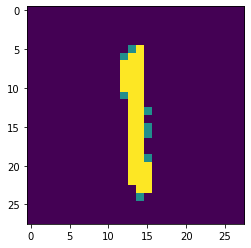

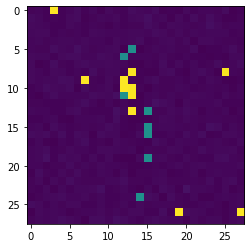

torch.Size([1, 28, 28])


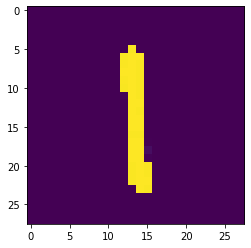

In [24]:
with torch.no_grad():
    for data, label in val_iterator:
        ground_truth = toImage(data[0])
        plt.imshow(ground_truth)
        plt.show()
        
        data = addNoise(data,noise_mean,noise_var) #(noise_mean**noise_var)*torch.randn([BATCH_SIZE,1, 28, 28])
        dirty_img = toImage(data[0])
        plt.imshow(dirty_img)
        plt.show()
        
        tensor = torch.unsqueeze(data[0],0).to(device)
        prediction = model(tensor)
        print(prediction[0].shape)
        pred_img = toImage(prediction[0])
        plt.imshow(pred_img)
        plt.show()
        break